# Vorhersage des Modelergebnisses auf Grundlage der Kostenfunktion

Im Folgenden wird untersucht, wie gut das entwickelte Modell die Kostenfunktion abschätzen kann.

Einmal wird nur das Klassifikationsmodell betrachtet, als Damage wird der Mittelwert über alle Transaktionen genommen.

Danach wird das Regresssionsmodell zur Vorhersage des Damage verwendet.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from xgboost import XGBClassifier, XGBRegressor

import fraud_detection as fd
from fraud_detection import data_loader, metrics
from fraud_detection.models.costoptim import bewertung

datapath = "../data/transformed_label_and_damage.parquet"
seed = 42

In [3]:
seed = 42

In [8]:
# lade Daten ohne die nutzlosen Features
X, targets = data_loader.load_data_np(datapath, drop_features=data_loader.useless_features)

In [9]:
def estimate_bewertung(preds, damages, gain_tp=5, cost_fp=10):
    """Estimate the bewertung value for given predictions and damages."""
    cost_control = preds * gain_tp - (1 - preds) * cost_fp
    cost_no_control = -(1 - preds) * damages
    costs = np.vstack([cost_control, cost_no_control])
    costs = costs.max(axis=0)
    return costs.sum()

In [25]:
def train_models_and_make_estimates(X_train, y_train, X_test, y_test, seed=42):
    """Train models and make estimates."""

    clf = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective="binary:logistic",
    )
    clf.fit(X_train, y_train[:, 0])

    probs = clf.predict_proba(X_test)[:, 1]
    preds = clf.predict(X_test)
    # hier muss der Mittelwert über alle Daten verwendet werden (auch NON-FRAUD)
    # da ansonsten die Kostenberechnung ausufern, weil die Wahrscheinlichkeiten
    # für NON-FRAUD zwar klein sind, aber nie wirklich null sind
    mean_damage = y_test[:, 1].mean()
    damage = np.full_like(probs, mean_damage)

    estimate_clf_only = estimate_bewertung(probs, damage, gain_tp=5, cost_fp=10)

    reg = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:squarederror",
        eval_metric="mae",
    )
    reg.fit(X_train, y_train[:, 1])

    damage_pred = reg.predict(X_test)
    estimate_combined = estimate_bewertung(probs, damage_pred, gain_tp=5, cost_fp=10)

    true_metrics = metrics.bewertung(probs, preds, y_test[:, 0], y_test[:, 1])

    cats = ["Bewertung", "damage_total", "damage_prevented", "damage_missed", "fp penalty", "detected bonus" ]
    # remove all metrics that are not relevant for the final output
    true_metrics = {cat: true_metrics[cat] for cat in cats}

    return {
        "nur Klassifikationsmodell": estimate_clf_only,
        "Klassifikation + Regression": estimate_combined,
        **true_metrics
    }


In [26]:
def run_experiment(X, targets, n_splits=5, n_repeats=1, random_state=42):

    # Initialize the RepeatedStratifiedKFold
    skf = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )

    df = pd.DataFrame()

    for i, (train_idx, test_idx) in enumerate(skf.split(X, targets[:, 0])):
        print(f"Fold {i + 1}/{n_splits * n_repeats}")
        results = train_models_and_make_estimates(X[train_idx], targets[train_idx], X[test_idx], targets[test_idx], seed=seed)
        df_fold = pd.DataFrame(results, index=[f"Fold {i + 1}"])
        df = pd.concat([df, df_fold], axis=0)

    return df


In [45]:
df = run_experiment(X, targets, n_splits=5, n_repeats=2, random_state=seed)

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [46]:
results = df

In [73]:
df = results.copy()
# renamee index
df.index = df.index.str.replace("Bewertung", "Tatsächliche Bewertun", regex=False)
df.index = df.index.str.replace("damage_total", "enthaltene Schadenssumme", regex=False)

df = df.loc[:, ["nur Klassifikationsmodell", "Klassifikation + Regression", "Bewertung", "damage_total"]]
# remove index
df = df.reset_index()
df.drop("index", inplace=True, axis=1)
# rename column
df.columns = [
    "Geschätzer Wert (nur Klassifikationsmodell)",
    "Geschätzer Wert (Klassifikation + Regression)",
    "Tatsächliche Bewertung",
    "enthaltene Schadenssumme"
]
df = df.astype(float)
df = df.round(2)
df

,Geschätzer Wert (nur Klassifikationsmodell),Geschätzer Wert (Klassifikation + Regression),Tatsächliche Bewertung,enthaltene Schadenssumme
0,-4325.20,-831.48,-917.32,5973.03
1,-4197.40,-813.79,-691.86,6010.35
2,-4454.44,-792.09,-1154.39,6153.55
3,-4176.69,-795.72,-1203.09,5867.81
4,-4340.73,-736.74,-831.59,6071.08
5,-4417.86,-745.20,-911.88,6123.70
6,-4010.87,-672.88,-885.58,5803.43
7,-4302.13,-870.83,-1015.35,5929.93
8,-4606.48,-754.05,-1288.66,6327.26
9,-4131.81,-840.83,-828.53,5891.50


In [74]:
df.T

,0,1,2,3,4,5,6,7,8,9
Geschätzer Wert (nur Klassifikationsmodell),-4325.20,-4197.40,-4454.44,-4176.69,-4340.73,-4417.86,-4010.87,-4302.13,-4606.48,-4131.81
Geschätzer Wert (Klassifikation + Regression),-831.48,-813.79,-792.09,-795.72,-736.74,-745.20,-672.88,-870.83,-754.05,-840.83
Tatsächliche Bewertung,-917.32,-691.86,-1154.39,-1203.09,-831.59,-911.88,-885.58,-1015.35,-1288.66,-828.53
enthaltene Schadenssumme,5973.03,6010.35,6153.55,5867.81,6071.08,6123.70,5803.43,5929.93,6327.26,5891.50


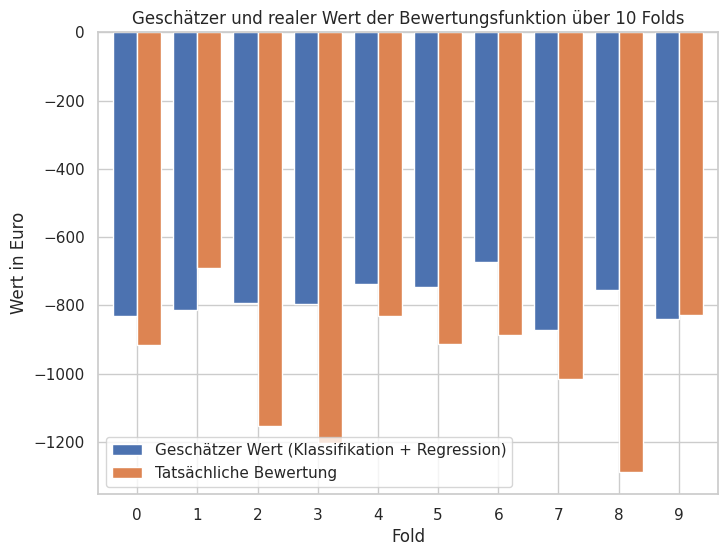

In [80]:
sns.set_theme(style="whitegrid")
df.loc[:, ["Geschätzer Wert (Klassifikation + Regression)", "Tatsächliche Bewertung"]].plot.bar(
    figsize=(8, 6),
    title="Geschätzer und realer Wert der Bewertungsfunktion über 10 Folds",
    ylabel="Wert in Euro",
    xlabel="Fold",
    rot=0,
    width=0.8
)
plt.show()